# Upday Assignment


1. Library and Data Import
2. A little Analysis
3. Data Cleansing and Preparation
4. Text Vectorization w/ Doc2Vec
5. A bit more Data Preparation and Test/Train Splitting
6. Stratified Cross Validation
7. Evaluation
8. Result

# 1. Library and Data Import
Let's get started with the easiest part of this task. Importing libraries, getting the necessary stopwords and importing the Dataset

In [397]:
import pandas as pd
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import nltk
from nltk.tokenize import word_tokenize

In [398]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     C:\Users\D\AppData\Roaming\nlt

True

In [399]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [400]:
df = pd.read_csv('data_redacted.tsv', sep='\t')

# 2. A little Analysis

In [401]:
df.head()

,title,text,url,category
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports
3,Secondary tropical forests absorb carbon at hi...,Forests are an important carbon sink. While mo...,http://www.sciencedaily.com/releases/2016/02/1...,technology_science
4,This Brow Hack Will Change the Way You Fill In...,Before everyone was trying to get eyebrows on ...,http://www.popsugar.com/beauty/How-Use-Brow-Ge...,fashion_beauty_lifestyle


We are able to see that the dataset consists of the target feature "category" as well as full article text, the headline and url. At first glance, it looks promising. 

In [402]:
df.shape

(8646, 4)

Our dataset contains 8467 articles and fortunately, we do not have any missing values :D

In [403]:
df.isnull().sum()

title       0
text        0
url         0
category    0
dtype: int64

Let's check the distribution of the target feature - We see the majority class as "fashion, beauty and lifestyle" (which are my favorite topics, of course), which represents roughly 16% of the data.

We can use this info as our minimum baseline, since we could without any effort predict all cases as the majority class and hence yield an accuracy of about 16%, given the dataset is a an accurate sample of reality.

In [404]:
round(df['category'].value_counts(normalize=True)*100, 2)

fashion_beauty_lifestyle    16.17
sports                      13.47
technology_science          12.03
digital_life                 8.54
money_business               8.48
news                         7.47
music                        6.57
culture                      6.33
travel                       6.29
cars_motors                  5.44
politics                     4.97
people_shows                 4.24
Name: category, dtype: float64

In [405]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

But no Juypter Notebook is complete without some bars, plots and colors, so here we go. The results match the ones you see above.

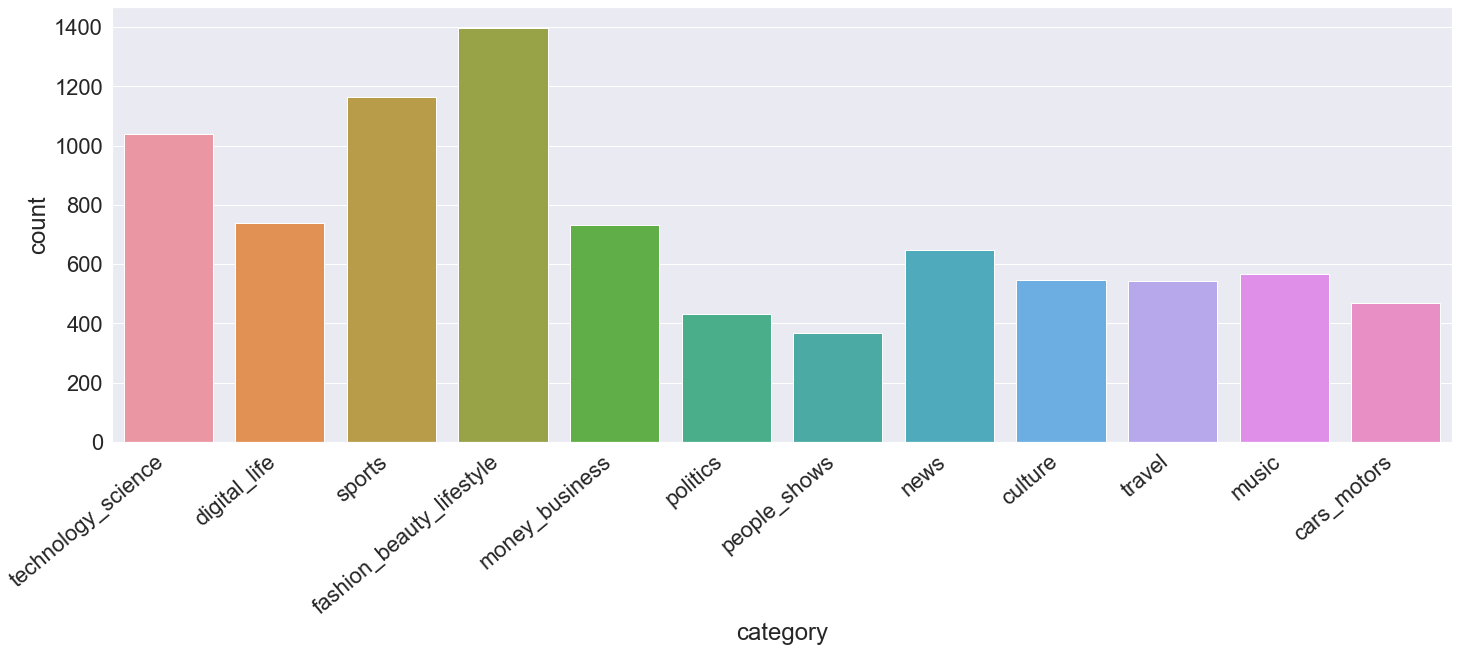

In [406]:
plt.figure(figsize=(24, 8))
sns.set(font_scale=2)
ax = sns.countplot(x="category", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

It's time for Data Cleansing and Preparation. Now the fun part starts - NOT! 
For the article body and headline we Step by step: 

1. convert all text into lowercase
2. Remove all the stopwords
3. Remove all non-alphabetic characters
4. Tokenize words for further processing

For the URL, we do it a bit differently, focusing on extracting the name of the news outlet producing the outlet. So we mainly use some REGEX magic (YESSS!) 

In [407]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['text'] = df['text'].str.replace('[^a-zA-Z ]', '', regex=True)
df['text'] = df['text'].str.replace('  ', ' ', regex=True)
df['token_text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)

In [408]:
df['title'] = df['title'].str.lower()
df['title'] = df['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df['title'] = df['title'].str.replace('[^a-zA-Z ]', '', regex=True)
df['title'] = df['title'].str.replace('  ', ' ', regex=True)
df['token_title'] = df.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)

In [409]:
df['url'] = df['url'].str.replace('http://www.', '', regex=True)
df['url'] = df['url'].str.replace('https://www.', '', regex=True)
df['url'] = df['url'].str.replace('https://', '', regex=True)
df['url'] = df['url'].str.replace('http://', '', regex=True)
df['outlet'] = df['url'].str.split('.').str[0]
df['token_outlet'] = df.apply(lambda row: nltk.word_tokenize(row['outlet']), axis=1)

Result's looking good!

In [410]:
df[['token_text', 'token_outlet', 'token_title']].head()

,token_text,token_outlet,token_title
0,"[human, chromosome, may, vanish, one, day, per...",[discovermagazine],"[dont, mourn, chromosome]"
1,"[bungie, putting, together, plans, start, sell...",[ibtimes],"[destiny, bungie, introduce, ammo, pack, micro..."
2,"[highly, rated, jehan, daruvala, race, josef, ...",[thecheckeredflag],"[daruvala, race, josef, kaufmann, racing]"
3,"[forests, important, carbon, sink, attention, ...",[sciencedaily],"[secondary, tropical, forests, absorb, carbon,..."
4,"[everyone, trying, get, eyebrows, fleek, mom, ...",[popsugar],"[brow, hack, change, way, fill, arches]"


Our target feature is also represented alphabetically, so we use a label encoder to assign a number to each class

In [411]:
le = LabelEncoder()

In [412]:
df['category_encoded'] = le.fit_transform(df['category'].values)

In [413]:
df[['category_encoded', 'category']][:15]

,category_encoded,category
0,10,technology_science
1,2,digital_life
2,9,sports
3,10,technology_science
4,3,fashion_beauty_lifestyle
5,3,fashion_beauty_lifestyle
6,4,money_business
7,10,technology_science
8,8,politics
9,8,politics


# 4. Text Vectorization w/ Doc2Vec

After the ungrateful task of data preprocessing, we are nearing the exciting part. BUT some more data preprocessing so that the tokenized text data is in the proper format for Doc2Vec to embed it into lots of vectors.

In [414]:
df['tagtext'] = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['token_text'])]
df['tagtitle'] = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['token_title'])]
df['tagoutlet'] = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['token_outlet'])]

Once this is done - we train the one layer neural network to extract features from the text data and embed them into vectors. 

I use different parameter settings for the different inputs - since the text body contains by far the most content, we choose a vector size of 300 with 40 epochs of training. 100 vector size/10 epochs for the headlines and 20 vector size / 10 epochs for just the outlet. Depending on your computational capabilities/restrictions - feel free to go bigger or smaller, but I am sure these parameters will yield a decent enough result.

In [415]:
model_text = Doc2Vec(vector_size = 300, workers = 4, min_count=2, epochs=40)
model_text.build_vocab(df['tagtext'])
model_text.train(df['tagtext'], total_examples=model_text.corpus_count, epochs=model_text.epochs)

In [416]:
model_title = Doc2Vec(vector_size = 100, workers = 4, min_count=2, epochs=10)
model_title.build_vocab(df['tagtitle'])
model_title.train(df['tagtitle'], total_examples=model_title.corpus_count, epochs=model_title.epochs)

In [417]:
model_outlet = Doc2Vec(vector_size = 20, workers = 4, min_count=1, epochs=10)
model_outlet.build_vocab(df['tagoutlet'])
model_outlet.train(df['tagoutlet'], total_examples=model_outlet.corpus_count, epochs=model_outlet.epochs)

When then put the respective Vectors into 3 separate lists and append them to our dataframe.

In [418]:
txtvecs = []
for i in range(len(df)):
    txtvecs.append(model_text.docvecs[i])
    
titvecs = []
for i in range(len(df)):
    titvecs.append(model_title.docvecs[i])

outvecs =  []
for i in range(len(df)):
    outvecs.append(model_outlet.docvecs[i])

In [419]:
df['textvecs'] = txtvecs
df['titlevecs'] = titvecs
df['outletvecs'] = outvecs

# 5. A bit more Data Preparation and Test/Train Splitting# 

In order, though, to make the vectors readable for our Classifier Algorithm, we must unpack each vector into a separate row/column

In [420]:
txtdf = pd.DataFrame(df.textvecs.values.tolist(), index= df.index)
txtdf.columns  = [str(col) + '_textvecs' for col in txtdf.columns]

titdf = pd.DataFrame(df.titlevecs.values.tolist(), index= df.index)
titdf.columns  = [str(col) + '_titlevecs' for col in titdf.columns]

outdf = pd.DataFrame(df.outletvecs.values.tolist(), index= df.index)
outdf.columns  = [str(col) + '_outvecs' for col in outdf.columns]

In [421]:
train = pd.concat([txtdf, titdf, outdf], axis=1)

Which look like this - A (not really) deep learning derived numerical representation of articles about Kim Kardashian, Donald Trump and Manchester United

In [422]:
train.head()

,0_textvecs,1_textvecs,2_textvecs,3_textvecs,4_textvecs,5_textvecs,6_textvecs,7_textvecs,8_textvecs,9_textvecs,...,10_outvecs,11_outvecs,12_outvecs,13_outvecs,14_outvecs,15_outvecs,16_outvecs,17_outvecs,18_outvecs,19_outvecs
0,-0.873681,-0.532906,-1.440502,-0.819636,-0.700342,1.956952,-1.234975,0.517912,0.547437,-0.674750,...,-0.011776,-0.016750,-0.014217,0.014764,-0.014962,0.001283,-0.018393,0.008031,0.005103,-0.002779
1,-2.114812,-0.505690,0.082704,-0.356038,1.307876,1.175859,0.151955,0.719878,0.632447,-0.620707,...,-0.021823,-0.023175,0.010567,-0.022525,0.000756,0.014780,-0.013243,0.019702,0.000455,0.003723
2,-1.158395,-0.245952,-0.778785,-0.980469,-0.340084,0.004507,-0.179437,-0.379394,-0.257295,-0.455203,...,-0.018454,0.009801,0.005954,-0.008872,-0.002938,0.017575,-0.004335,0.023667,0.021546,0.011723
3,-1.668229,-0.811162,-0.792308,-0.877829,0.618063,-0.011824,-0.686522,1.003237,-0.376461,1.900979,...,0.002713,0.022808,0.020478,-0.003798,0.015350,-0.002300,0.001431,-0.004734,-0.023161,-0.014504
4,0.648218,0.245733,-1.330782,0.471200,0.273002,0.768581,-0.578169,0.216960,-0.383337,-0.662962,...,-0.021323,-0.014846,-0.023325,-0.003831,-0.023742,-0.018876,0.005292,0.018105,-0.024468,-0.019683


Before you ask - It is fine to perform the embedding on the whole data, because the training is fully unsupervised. Lau and Baldwin (2016) explain this in detail here: https://arxiv.org/pdf/1607.05368.pdf

We use 2/3 to 1/3 split for training and test data. We shuffle the data to remove any possible order, but stratify the data to make sure the distribution is equal in both splits. We do this under the assumption of the data being a good sample of reality, so why not use this advantage if it is available to us a priori?

In [423]:
X_train, X_test, y_train, y_test = train_test_split(train, df['category_encoded'], test_size=0.33, random_state=42, stratify=y)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

# 6. Parameter Tuning AND Stratified Cross Validation (at the same time!!!)

In [424]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, KFold

From my years of experience as a data scientist, I feel that gradient boosting ensemble classifiers always work pretty well for a many different data sets. Also, consider that the time investment in order to test and tune all sorts of different algorithms is very time consuming (trust me, I've been there and done that), so my approach is to follow my intuition and assess whether the result is viable. If that is the case (and I know it is, because my intuition never fails me), then you can focus on putting this viable model version 1 in production and while it already makes money, you can go back to try other algorithms for a possibly better version 1.1

For the metric, I wanted to use multilabel_log_loss as it also conveys information about the probabilites and confidence of an classification BUT the sklearn implementation is quite buggy, so I settled for Macro F1 score as no class has a huge majority and macro average treats all classes equally, so that minority classes influence is somewhat artifically boosted, which I think will lead to a higher micro f1 score compared the macro score, since it is my feeling that minority classes are harder to predict.

In [425]:
xgb = XGBClassifier()
f1 = f1_score
ll = make_scorer(f1_score, greater_is_better=True, labels=y_train, average='macro')
kf = KFold(n_splits=10, shuffle=True)

The parameter space from which the optimized parameters are taken from: 

In [426]:
params_xgb = {"n_estimators": [10,20,50,100],
              "max_depth": range(1, 11),
              "learning_rate": [1e-3, 1e-2, 1e-1, 0.5, 1.],
              "subsample": np.arange(0.05, 1.01, 0.05),
              "min_child_weight": range(1, 21),
              "colsample_bytree": np.arange(0.1,1,0.1),
              "reg_lambda": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
              "reg_alpha": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],

              }


In [427]:
random_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=params_xgb, cv=kf, scoring=ll, n_iter=5,
                                random_state=42, verbose=10)
random_xgb.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           object...
                                                       15.0, 20.0, 25.0],
                                        'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9

After running the cross validation, we receive the parameters of the best estimator - that is the estimator with the best average metric performance, which we also see below.

Luckily, my intuition has not failed me and we get a very satisfactory F1 macro score of roughly 76.

In [428]:
print(random_xgb.best_estimator_)
print("Mean f1 macro score xgb:", round(random_xgb.best_score_*100, 2))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7000000000000001, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=10,
              min_child_weight=6, missing=None, n_estimators=20, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=10.0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.4, verbosity=1)
Mean f1 macro score xgb: 76.43


# 7. Fitting, Metrics and Evaluation


In [429]:
bestxgb = random_xgb.best_estimator_

Before we celebrate, though, we must be sure that we haven't overfitted the model (Although k-fold CV is already a measure to avoid this). So let's fit the entire training data and run a prediction on some fully unseen data, that we held out when we split the data set.

In [430]:
bestxgb.fit(X_train, y_train)
y_pred = bestxgb.predict(X_test)

Before we get the result, let's also introduce the good ol' accuracy score as our baseline pertains to it.

In [431]:
final_f1 = f1_score(y_test, y_pred, average='macro')*100
acc = accuracy_score(y_test, y_pred)

Here we create a np array, that only consists of the number 3, which is the label of the majority class "fashion and beauty"

In [432]:
y_pred_base = np.full((2854, ), 3)

# 8. Result

Had we just used the majority label as a prediction, we would have received a macro f1 score of 2.3, an f1 micro score of 16.15 as well as an accuracy of 16.15%, which is waaaaaaay worse than what our k-fold CV has yielded.

In [433]:
print ("Baseline F1 Macro Score:", round(f1_score(y_test, y_pred_base, average='macro')*100, 2))
print ("Baseline F1 Micro Score:", round(f1_score(y_test, y_pred_base, average='micro')*100, 2))
print ("Baseline Accuracy Score:", round(accuracy_score(y_test, y_pred_base)*100, 2),'%')

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Baseline F1 Macro Score: 2.32
Baseline F1 Micro Score: 16.15
Baseline Accuracy Score: 16.15 %


But now comes the moment of truth and we see how our model has performed on never before seen data. And the result confirms our very promising CV results. 

F1 Macro Score: 74.52
F1 Micro Score: 75.89
Accuracy Score: 75.89 %

In [434]:
print ("Test set F1 Macro Score:", round(f1_score(y_test, y_pred, average='macro')*100, 2))
print ("Test set F1 Micro Score:", round(f1_score(y_test, y_pred, average='micro')*100, 2))
print ("Test set Accuracy Score:", round(accuracy_score(y_test, y_pred)*100, 2),'%')

Test set F1 Macro Score: 74.52
Test set F1 Micro Score: 75.89
Test set Accuracy Score: 75.89 %


In the End let's take a look at the Confusion matrix as an additional way to visualize the result. It provides us with a more in-depth non-numeric possibility to assess the result:

For example, the categories "news" and "politics" are often confused with each other, which makes sense since they seem very similar and related. Same with "Culture" and "music".

These are insights that we couldn't have extracted from just numeric metrics. Using the confusion matrix might help us to recognize that we should not just tinker with the algorithms themselves but also reassess the way we define categories. 

Instead of manually defining categories, why not for example use some unsupervised learning to find clusters based on the the text of an article? These clusters can then be assessed for their suitability as new categories.

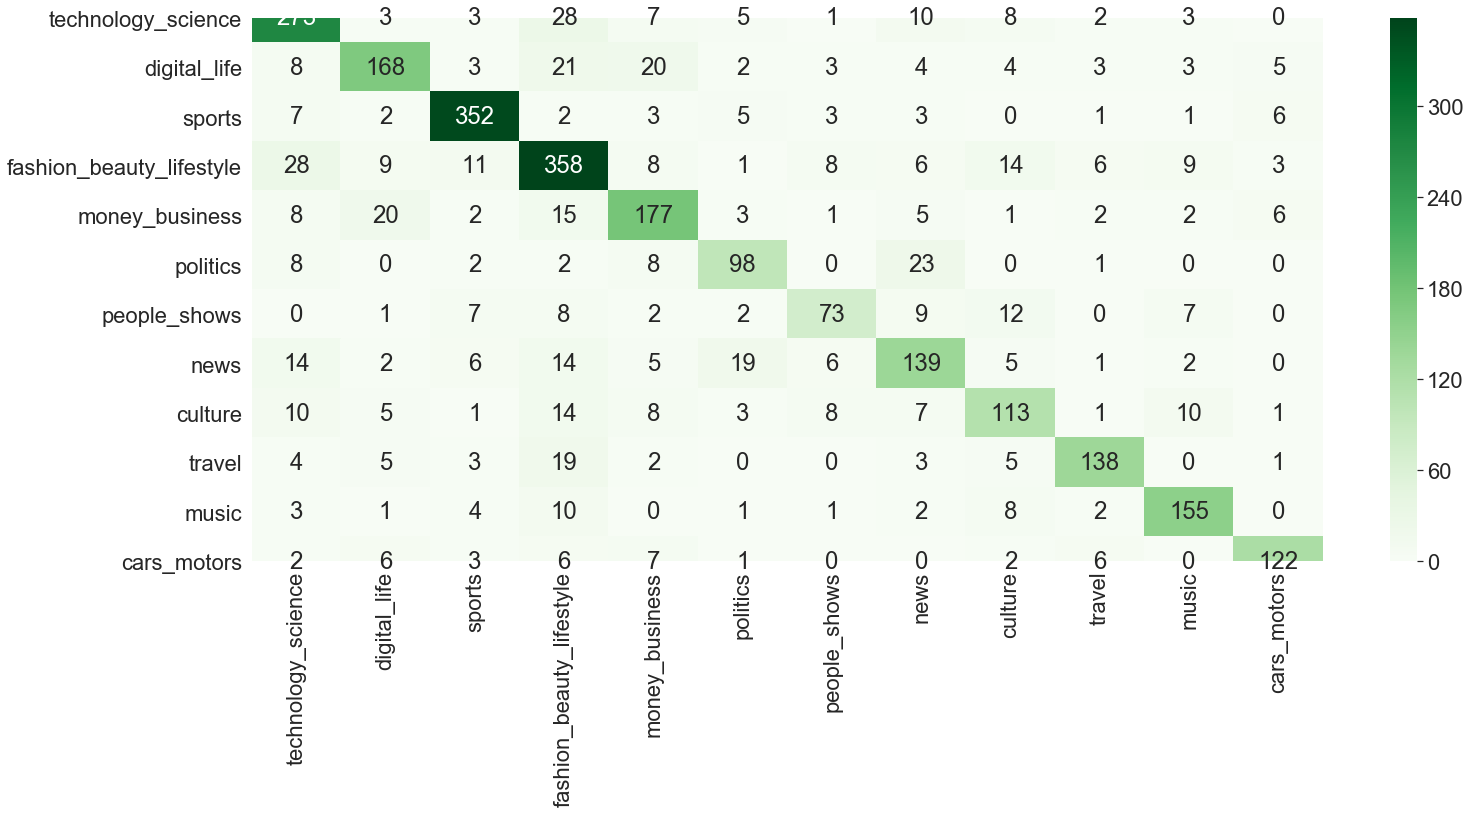

In [435]:
from sklearn.metrics import confusion_matrix

y_pred_lb = le.inverse_transform(y_pred)
y_test_lb = le.inverse_transform(y_test)

labels = ['technology_science', 'digital_life', 'sports',
       'fashion_beauty_lifestyle', 'money_business', 'politics',
       'people_shows', 'news', 'culture', 'travel', 'music',
       'cars_motors']
cm = confusion_matrix(y_test_lb, y_pred_lb, labels)
plt.figure(figsize=(24, 10))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g',xticklabels=labels, yticklabels=labels, cmap='Greens')